In [ ]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 
import albumentations as albu

sys.path.append("..")

from IPython import display

# %load_ext autoreload
# %autoreload 2

In [ ]:
# sys.path.append("/home/zakirov/repoz/metrics-comparison/")
# sys.path.append("../")

## Download datasets

In [ ]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)
# fashin_mnist = torchvision.datasets.FashionMNIST("datasets", download=True)

In [ ]:
# !wget -P datasets/ http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !wget -P datasets/ http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
# !wget -P datasets/ http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip

## Test datasets

In [2]:
from src.augmentations import get_aug
from src.utils import walk_files
from src.datasets import *
from torch.utils.data import Dataset

In [3]:
task = "denoise"
# transform = get_aug(aug_type="light", task=task, dataset="mnist", size=28)
# mnist = MNIST(root="datasets/", train=True, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="fashion_mnist", size=28)
# fashionmnist = FashionMNIST(root="datasets/", train=True, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="cifar10", size=32)
# cifar10 = CIFAR10(root="datasets/", train=True, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="cifar100", size=32)
# cifar100 = CIFAR100(root="datasets/", train=True, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="tinyimagenet", size=64)
# tiny = TinyImageNet(train=True, transform=transform)

transform = get_aug(aug_type="medium", task=task, dataset="div2k", size=256)
div2k = DIV2K(train=True, transform=transform)

transform = get_aug(aug_type="medium", task=task, dataset="set5", size=256)
set5 = Set5(train=False, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="set14", size=128)
# set14 = Set14(train=False, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="urban100", size=128)
# urban100 = Urban100(train=False, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="manga109", size=128)
# manga109 = Manga109(train=False, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="coil100", size=128)
# coil100 = COIL100(train=False, transform=transform)

transform = get_aug(aug_type="medium", task=task, dataset="bsds100", size=256)
bsds100 = BSDS100(train=False, transform=transform)

# transform = get_aug(aug_type="light", task=task, dataset="medicaldecathlon", size=256)
# medicaldecathlon = MedicalDecathlon(train=False, transform=transform)

In [4]:
datasets = [
#     mnist, 
#     fashionmnist,
#     cifar10, 
#     cifar100,
#     tiny, 
    div2k, 
    set5, 
#     set14,
#     urban100, 
#     manga109, 
#     coil100, 
    bsds100,
#     medicaldecathlon,
]

In [ ]:
# total_mean, total_var = [], []
# for i in range(len(div2k)):
#     image = div2k[i][1]
#     total_mean.append(image.mean(dim=[1,2]))
#     total_var.append(image.var(dim=[1,2]))
# print(torch.stack(total_mean).mean(dim=0))
# print(torch.stack(total_var).mean(dim=0))



Input torch.Size([3, 256, 256]) tensor(-1.) tensor(1.) tensor(-0.2190)
Target torch.Size([3, 256, 256]) tensor(-1.) tensor(1.) tensor(-0.2127)


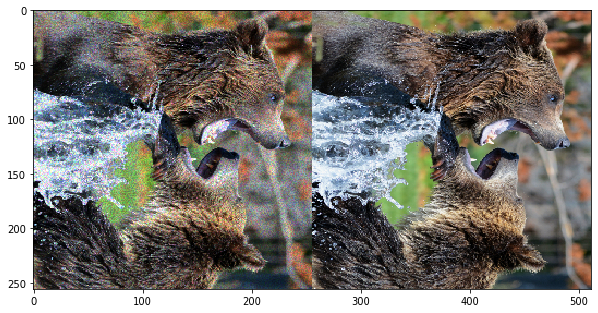

Input torch.Size([3, 256, 256]) tensor(-1.) tensor(1.) tensor(-0.0874)
Target torch.Size([3, 256, 256]) tensor(-1.) tensor(1.) tensor(-0.0779)


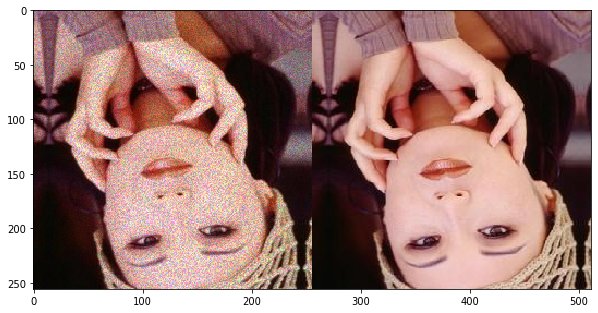

Input torch.Size([3, 256, 256]) tensor(-0.9843) tensor(1.) tensor(-0.2663)
Target torch.Size([3, 256, 256]) tensor(-1.) tensor(0.8118) tensor(-0.2624)


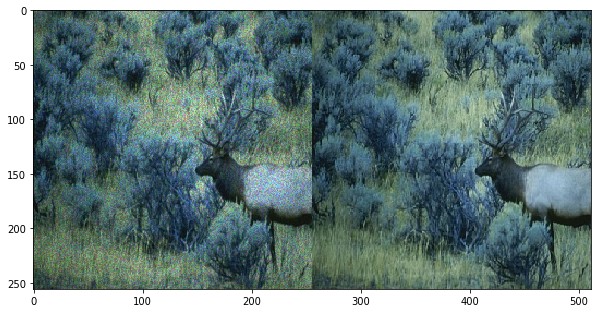

In [5]:
for dataset in datasets[:]:
    print(dataset)
    input, target = dataset[1]
    print("Input", input.shape, input.min(), input.max(), input.mean())
    print("Target", target.shape, target.min(), target.max(), target.mean())
    plt.figure(figsize=(10, 15))
    plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0) * 0.5 + 0.5, )
    plt.show()
    

In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="denoise", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="deblur", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
print(image.min(), image.max(), image.mean())

In [ ]:
# idx = 356
print(image[..., 0].min(), image[..., 0].max(), image[...,0].mean())
# plt.hist()
# print(image.min(), image.max(), image.mean())
# grey_image = image[..., 0]
augmented = AUG(image=image, mask=image)
input, target = augmented["image"], augmented["mask"]

## Get gaussian
# random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
# gauss = random_state.normal(0, 0.1, input.shape)
# input = input + gauss
# gauss

# print("Input", input.shape, input.min(), input.max())
# print("Target", target.shape, target.min(), target.max())

# augmented = NORM_TO_TENSOR(image=input, mask=target)
# input, target = augmented["image"], augmented["mask"]

print("Input", input.shape, input.min(), input.max())
print("Target", target.shape, target.min(), target.max())
plt.figure(figsize=(10, 10))
plt.imshow(torch.cat([input[0], target[0]], dim=1)) #.permute(1, 2, 0))
# plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))

torch.sum(input - target)

In [ ]:
torch.mean(input - target)

In [ ]:
plt.imshow((medicaldecathlon[idx][0][..., 0]))

In [ ]:
a = np.random.rand(256, 256)
a = a[:,:,np.newaxis].repeat(3, axis=2)
# a.repeat(3, axis=0).shape

In [ ]:
plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0)[:, :, [2, 1, 0]])

## Test dataloaders

In [6]:
from src.datasets import get_dataloader

In [17]:
datasets = ["div2k", "bsds100", "set5"]
transform = get_aug(aug_type="val", task="deblur", size=128)

for dataset in datasets:
#     train_loader = get_dataloader(dataset, transform, train=True, batch_size=64)
    
#     for batch in train_loader:
#         input, output = batch
#         print(input.shape, output.shape)
        
    
    val_loader = get_dataloader(dataset, transform, train=False)
    for batch in val_loader:
        input, output = batch
        print(input.shape, output.shape)
    
    
    for batch in train_loader:
        break


Using datasets: div2k. Validation size: 100.


RuntimeError: stack expects each tensor to be equal size, but got [3, 774, 1020] at entry 0 and [3, 678, 1020] at entry 1

In [15]:
dataset = BSDS100("datasets/BSDS100", train=True, transform=transform)
dataset[0][0].size()

torch.Size([3, 128, 128])

In [ ]:
import photosynthesis_metrics as pm
image_metrics = ["kid", {}, "ssim", {}, ]

METRIC_FROM_NAME = {
    "ssim" : pm.SSIMLoss,
    "ms-ssim" : pm.MultiScaleSSIMLoss,
    "msid" : pm.MSID,
    "fid" : pm.FID,
    "kid" : pm.KID,
#     "content" : ContentLoss,
#     "style" : StyleLoss,
    "tv" : pm.TVLoss,
}


# for metric in image_metrics:
image_metrics = [METRIC_FROM_NAME[metric](**kwargs) for metric, kwargs in zip(image_metrics[::2], image_metrics[1::2])]
# list(zip(image_metrics[::2], image_metrics[1::2]))
image_metrics

In [ ]:
from collections import OrderedDict
output = OrderedDict({
    'loss': 1,
#     'mse': mse,
#     'psnr': psnr,
#     'ssim': ssim_score,
#     # 'val_ms_ssim': ms_ssim_score,
#     'input_features': input_features,
#     'target_features': target_features
})
output["test"] = 3
output["foo"] = "bar"

In [ ]:
images = torch.rand((512, 2, 32, 32))
target = torch.rand((512, 2, 64, 64))
print(f"Before interpolation: images {images.shape}")
images = F.interpolate(images, size=target.shape[-2:], mode="bilinear")
print(f"After interpolation: images {images.shape}")

In [ ]:
# from functools import b
# 
iter()

In [ ]:
a = ["foo", "bar"]
if "foo" in a:
    print(a.index("foo"))
# a.append("loss")
# print(a)
# a.pop()
# a
# for i in "etc", a:
#     print(i)

In [ ]:
features = make_layers(
    [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"], 
    batch_norm=True
)
vgg_16 = VGG(features)

In [ ]:
vgg_16

In [ ]:
x = torch.rand(10, 3, 224, 224)
layers = None
if layers is None:
    layers = ["0", "5", "10", "19", "28"]

features = []
for name, module in vgg_16.features._modules.items():
    x = module(x)
    if name in layers:
        features.append(x)


In [ ]:
features

In [ ]:
# from albumentations import ImageOnlyTransform
albu.ImageCompression()

In [ ]:
target.permute(2, 0, 1).shape, input.shape

In [ ]:
plt.imshow(target.permute(2, 0, 1).transpose(0, 2).transpose(0, 1))

In [ ]:
dataset = TinyImageNetDataset(train=True, transform=None, target_transform=None)
input, target = dataset[6]
# input.shape
# plt.imshow(input / 255.)
(input / 255.).min(), (input / 255.).max()

In [ ]:
input.transpose(0, 2).transpose(0, 1).shape

In [ ]:
# dataset[0][0].shape

In [ ]:
# from src.augmentations import get_aug
# from src.datasets import MNIST, CIFAR10, CIFAR100
from ..src.datasets
# from src.datasets import get_dataloader

In [ ]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [ ]:
transform, target_transform

In [ ]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

In [ ]:
mock = torch.rand((3, 3, 32, 32))

In [ ]:
result = model(mock)

In [ ]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

In [ ]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

In [ ]:
input.shape, target.shape

In [ ]:
class HDRLoss(nn.Module):
    """High dynamic range loss."""

    def __init__(self, eps=0.01):
        """Initializes loss with numerical stability epsilon."""

        super(HDRLoss, self).__init__()
        self._eps = eps


    def forward(self, denoised, target):
        """Computes loss by unpacking render buffer."""

        loss = ((denoised - target) ** 2) / (denoised + self._eps) ** 2
        return loss.mean(dim=[1,2,3])

In [ ]:
hdr = HDRLoss()

In [ ]:
loss = hdr(target+ 0.001, target)
print(loss.shape)

In [ ]:
loss

In [ ]:
# show images
print(images.shape)
grid = torchvision.utils.make_grid(images[:16])
print(grid.shape)
imshow(grid)

In [ ]:
imshow(torchvision.utils.make_grid(target))

In [ ]:

# plt.imshow(image[:, :, 0])

In [ ]:
import photosynthesis_metrics as pm

In [ ]:
import h5py

In [ ]:
datapath = "datasets/decathlon/colon.h5"
with h5py.File(datapath, "r") as f:
    for key in f.keys():
        print(key)
#     data_val = f['imgs_validation'][::10]
#     data_test = f['imgs_testing'][::10]
#     data = np.concatenate((data_val, data_test))
#     print(data.shape)
#     print(len(data))
    

# hf = 
# data_numpy = np.zeros(hf['imgs_train'].shape, dtype=numpy_type)
# # hf['dataset_name'].read_direct(n1)
# # hf.close()

In [ ]:
data = hf['imgs_train'][5000]
mask = hf['msks_train'][5000]
plt.figure(figsize=(10, 10))
plt.imshow(data.squeeze(), cmap='gray')
# plt.imshow(mask.squeeze(), alpha=0.1)
# data.max()


In [ ]:
# data.max()


## Test photosynthesis.metrics

In [ ]:
import torch
import photosynthesis_metrics as pm

In [ ]:
# ON CPU
fid = pm.FID()
predicted = torch.rand(10000, 1000)#.to("cuda:0")
target = torch.rand(10000, 1000)#.to("cuda:0")
%timeit score = fid(predicted, target)

In [ ]:
# ON GPU
fid = pm.FID()
predicted = torch.rand(10000, 1000).to("cuda:0")
target = torch.rand(10000, 1000).to("cuda:0")
%timeit score = fid(predicted, target)

In [ ]:
predicted = torch.rand(10000, 1000)
predicted.shape[0]

In [ ]:
import torch                                                                                                                                                
import photosynthesis_metrics as pm                                                                                                                     
from torchvision.datasets import MNIST, FashionMNIST
mnist = MNIST(root="/home/zakirov/repoz/metrics-comparison/datasets", train=True)
mnist_data1 = mnist.data.reshape(-1, 784)[:10000]
mnist_data2 = mnist.data.reshape(-1, 784)[10000:]

fmnist = FashionMNIST(root="/home/zakirov/repoz/metrics-comparison/datasets", train=True)
fmnist_data1 = fmnist.data.reshape(-1, 784)[:10000]
fmnist_data2 = fmnist.data.reshape(-1, 784)[10000:]

gs = pm.GS(num_iters=10, sample_size=32)


In [ ]:
from multiprocessing import Pool
import numpy as np
import time

work = (["A", 5], ["B", 2], ["C", 1], ["D", 3])

# def work_log(work_data):
#     print(" Process %s waiting %s seconds" % (work_data[0], work_data[1]))
#     time.sleep(int(work_data[1]))
#     print(" Process %s Finished." % work_data[0])
#     return work_data[1]


def work_log(work_log):
    res = np.ones((10, ))
#     print("Hi")
    return res


p = Pool(2)
res = p.map(work_log, work)
np.vstack(res)#.shape
# p = Pool(2)
# res = p.imap_unordered(work_log, range(5))

    
# p = Pool(6)


# rlts = np.zeros((num_iters, i_max))
#     for i in range(num_iters):
#         rlts[i, :] = rlt(X, sample_size, gamma, i_max)
#     return rlts


In [ ]:
mnist_mnist = gs(mnist_data1, mnist_data2)  
fmnist_fmnist = gs(fmnist_data1, fmnist_data2)  

fmnist_mnist1 = gs(fmnist_data1, mnist_data2) 
fmnist_mnist2 = gs(mnist_data1, fmnist_data2)  

print(mnist_mnist, fmnist_fmnist, fmnist_mnist1, fmnist_mnist2)

# Inception score

In [ ]:
a = torch.randn(1)
a, torch.mean(a), torch.var(a)

# Compute IS for CIFAR10 dataset

In [ ]:
import torch
from torchvision import transforms
from torchvision.models import inception_v3                                                                                                                 
from torchvision.datasets import CIFAR10

import photosynthesis_metrics as pm    
from photosynthesis_metrics import IS
from tqdm.notebook import tqdm

In [ ]:
# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10 = CIFAR10(root="/home/zakirov/repoz/metrics-comparison/datasets", train=True, transform=aug)
cifar10
loader = torch.utils.data.DataLoader(cifar10, batch_size=100, num_workers=10)

In [ ]:
# model = pm.feature_extractors.fid_inception.InceptionV3(
#     resize_input=True, 
#     normalize_input=True,
#     requires_grad=False,
#     use_fid_inception=False,
# )
model = inception_v3(pretrained=True, transform_input=False).cuda()
model.eval()

In [ ]:
scores = []
i = 0
# num_batches = 20
with torch.no_grad():
    up = torch.nn.Upsample(size=(299, 299), mode='bilinear')
    for batch in tqdm(loader):
        images, labels = batch
#         images = images.permute(0, 3, 1, 2)
        images = up(images)
        output = model(images.cuda())
        scores.append(output.detach().cpu())
#         i += 1
#         if i == num_batches:
#             break

In [ ]:
cifar10_features = torch.cat(scores, dim=0)

# # Now compute the mean kl-div
# split_scores = []
# preds = torch.nn.functional.softmax(cifar10_features).data.cpu().numpy()
# N = len(preds)
# splits = 10
# for k in range(splits):
#     part = preds[k * (N // splits): (k+1) * (N // splits), :]
#     py = np.mean(part, axis=0)
#     sc = []
#     for i in range(part.shape[0]):
#         pyx = part[i, :]
#         sc.append(entropy(pyx, py))
#     split_scores.append(np.exp(np.mean(sc)))

# print(N, np.mean(split_scores), np.std(split_scores))
inception_score = IS(num_splits=10, ret_var=True)
inception_score(cifar10_features, cifar10_features)


In [ ]:
       
#     # Shape (1 x 3 x 32 x 3)
#     images = images.permute(0, 3, 1, 2)
#     images = F.interpolate(images,
#                   size=(299, 299),
#                   mode='bilinear',
#                   align_corners=False) 
        
        
    

# for batch in tqdm(loader):
#     images, labels = batch
# #     print(images.shape, images.min(), images.max())
#     # Shape (1 x 3 x 32 x 3)
#     images = images.permute(0, 3, 1, 2)
#     images = F.interpolate(images,
#                   size=(299, 299),
#                   mode='bilinear',
#                   align_corners=False) 
#     output = model(image)
#     scores.append(output)
# # for i in tqdm(range(num_batches)):
# #     images = cifar10.data[i * batch_size: (i+1) * batch_size]
# #     # To tensor. Shape (N x 32 x 32 x 3)
# #     image = torch.tensor(images)
# # #     print(image.shape)
# #     # Shape (1 x 3 x 32 x 3)
# #     image = image.permute(0, 3, 1, 2) / 255.0
# #     image = F.interpolate(image,
# #                   size=(299, 299),
# #                   mode='bilinear',
# #                   align_corners=False)
# #     output = model(image)
# #     scores.append(output)

In [ ]:
import torch.nn.functional as F

In [ ]:
torch.dist()

## Geometry score

In [ ]:
import photosynthesis_metrics as pm
import torch

In [ ]:
gs = pm.GS(num_iters=20)
f1 = torch.rand(1000, 20)
f2 = torch.rand(1000, 20)

In [ ]:
r""" This module implements Geometry Score (GS) in PyTorch.

Implementation is inspired by Valentin Khrulkov's (@KhrulkovV) implementation:
https://github.com/KhrulkovV/geometry-score

See paper for details:
https://arxiv.org/pdf/1802.02664.pdf
"""
from typing import Optional
from functools import partial
from multiprocessing import Pool

import torch
import numpy as np
import scipy
from scipy.spatial.distance import cdist

from photosynthesis_metrics.base import BaseFeatureMetric

In [ ]:
import gudhi

In [ ]:
def relative(intervals: np.ndarray, alpha_max: float, i_max: int = 100) -> np.ndarray:
    r"""
    For a collection of intervals this functions computes
    RLT by formulas (2) and (3) from the paper. This function will be typically called
    on the output of the gudhi persistence_intervals_in_dimension function.

    Args:
      intervals: list of intervals e.g. [[0, 1], [0, 2], [0, np.inf]].
      alpha_max: The maximal persistence value
      i_max: Upper bound on the value of beta_1 to compute.

    Returns:
        rlt: Array of size (i_max, ) containing desired RLT.
    """

    persistence_intervals = []
    # If for some interval we have that it persisted up to np.inf
    # we replace this point with alpha_max.
    for interval in intervals:
        if not np.isinf(interval[1]):
            persistence_intervals.append(list(interval))
        elif np.isinf(interval[1]):
            persistence_intervals.append([interval[0], alpha_max])

    # If there are no intervals in H1 then we always observed 0 holes.
    if len(persistence_intervals) == 0:
        rlt = np.zeros(i_max)
        rlt[0] = 1.0
        return rlt

    persistence_intervals_ext = persistence_intervals + [[0, alpha_max]]
    persistence_intervals_ext = np.array(persistence_intervals_ext)
    persistence_intervals = np.array(persistence_intervals)

    # Change in the value of beta_1 may happen only at the boundary points
    # of the intervals
    switch_points = np.sort(np.unique(persistence_intervals_ext.flatten()))
    rlt = np.zeros(i_max)
    for i in range(switch_points.shape[0] - 1):
        midpoint = (switch_points[i] + switch_points[i + 1]) / 2
        s = 0
        for interval in persistence_intervals:
            # Count how many intervals contain midpoint
            if midpoint >= interval[0] and midpoint < interval[1]:
                s = s + 1
        if (s < i_max):
            rlt[s] += (switch_points[i + 1] - switch_points[i])

    return rlt / alpha_max


def lmrk_table(W: np.ndarray, L: np.ndarray):
    r"""Construct an input for the gudhi.WitnessComplex function.
    Args:
        W: Array of size w x d, containing witnesses
        L: Array of size l x d, containing landmarks

    Returns:
        distances: 3D array of size w x l x 2. It satisfies the property that
            distances[i, :, :] is [idx_i, dists_i], where dists_i are the sorted distances 
            from the i-th witness to each point in L and idx_i are the indices of the corresponding points
            in L, e.g., D[i, :, :] = [[0, 0.1], [1, 0.2], [3, 0.3], [2, 0.4]]
        max_dist: Maximal distance between W and L
    """
    a = cdist(W, L)
    max_dist = np.max(a)
    idx = np.argsort(a)
    b = a[np.arange(np.shape(a)[0])[:, np.newaxis], idx]
    distances = np.dstack([idx, b])
    return distances, max_dist

In [ ]:
def witness(X, sample_size: int = 64, gamma: Optional[float] = None):
    """Compute the persistence intervals for the dataset X using the witness complex.

    Args:
        X: Array of shape (N_samples, data_dim) representing the dataset.
        sample_size: Number of landmarks to use on each iteration.
        gamma: Parameter determining maximum persistence value. Default is `1.0 / 128 * N_imgs / 5000`

    Returns
        A list of persistence intervals and the maximal persistence value.
    """
    # Install gudhi only if needed
    try:
        import gudhi
    except ImportError as e:
        import six
        error = e.__class__(
            "You are likely missing your GUDHI installation, "
            "you should visit http://gudhi.gforge.inria.fr/python/latest/installation.html "
            "for further instructions.\nIf you use conda, you can use\nconda install -c conda-forge gudhi"
        )
        six.raise_from(error, e)

    N = X.shape[0]
    if gamma is None:
        gamma= 1.0 / 128 * N / 5000

    # Randomly sample `sample_size` points from X
    idx = np.random.choice(N, sample_size)
    landmarks = X[idx]

    distances, max_dist = lmrk_table(W=X, L=landmarks)
    wc = gudhi.WitnessComplex(distances)
    alpha_max = max_dist * gamma
    st = wc.create_simplex_tree(max_alpha_square=alpha_max, limit_dimension=2)

    # This seems to modify the st object
    st.persistence(homology_coeff_field=2)
    intervals = st.persistence_intervals_in_dimension(1)
    return intervals, alpha_max

In [ ]:
def rlt(
    idx: int, X: np.ndarray, sample_size: int = 64, gamma: Optional[float] = None, i_max: int = 100) -> np.ndarray:
    """Implements Algorithm 1 for one sample of landmarks.
 
    Args:
        idx : Used for multiprocessing.Pool to work correctly
        X: Array of shape (N_samples, data_dim) representing the dataset.
        sample_size: Number of landmarks to use on each iteration.
        gamma: Parameter determining maximum persistence value. Default is `1.0 / 128 * N_imgs / 5000`
        i_max: Upper bound on the value of beta_1 to compute.
    
    Returns:
      An array of size (i_max, ) containing RLT(i, 1, X, L)
        for randomly sampled landmarks.
    """
    intervals, alpha_max = witness(X, sample_size=sample_size, gamma=gamma)
    result = relative(intervals, alpha_max, i_max=i_max)
    return result

In [ ]:
def rlts(X: np.ndarray, 
    sample_size: int = 64, num_iters: int = 200, gamma: Optional[float] = None, i_max: int = 100) -> np.ndarray:
    r"""Implements Algorithm 1 from the paper.

    Args:
        X: Array of shape (N_samples, data_dim) representing the dataset.
        sample_size: Number of landmarks to use on each iteration.
        num_iters: Number of iterations. 
        gamma: Parameter determining maximum persistence value. Default is `1.0 / 128 * N_imgs / 5000`
        i_max: Upper bound on the value of beta_1 to compute.

    Returns:
        rlts: Array of size (num_iters, i_max) containing RLT(i, 1, X, L) for
            `num_iters` collection of randomly sampled landmarks.
    """
    sample_rlts = np.zeros((num_iters, i_max))
    for i in range(num_iters):
        sample_rlts[i, :] = rlt(idx=None, X=X, sample_size=sample_size, gamma=gamma, i_max=i_max)
    return sample_rlts

In [ ]:
def parallel_rlts(X: np.ndarray, sample_size: int = 64, num_iters: int = 200, 
                  gamma: Optional[float] = None, i_max: int = 100, num_workers=4) -> np.ndarray:
    r"""Implements Algorithm 1 from the paper.
    Uses multiprocessing.Pool to make computations fastes. 

    Args:
        X: Array of shape (N_samples, data_dim) representing the dataset.
        sample_size: Number of landmarks to use on each iteration.
        num_iters: Number of iterations. 
        gamma: Parameter determining maximum persistence value. Default is `1.0 / 128 * N_imgs / 5000`
        i_max: Upper bound on the value of beta_1 to compute.

    Returns:
        rlts: Array of size (num_iters, i_max) containing RLT(i, 1, X, L) for
            `num_iters` collection of randomly sampled landmarks.
    """
    partial_rlt = partial(rlt, X=X, sample_size=sample_size, gamma=gamma, i_max=i_max)

    # Use 6 processes by default
    p = Pool(num_workers)
    pool_result = p.map(partial_rlt, range(num_iters))
    rlts = np.vstack(pool_result)
    return rlts

In [ ]:
class GS(BaseFeatureMetric):
    r"""Interface of Geometry Score.
    It's computed for a whole set of data and can use features from encoder instead of images itself to decrease
    computation cost. GS can compare two data distributions with different number of samples.
    But dimensionalities should match, otherwise it won't be possible to correctly compute statistics.

    Args:
        predicted_features (torch.Tensor): Low-dimension representation of predicted image set. Shape (N_pred, encoder_dim)
        target_features (torch.Tensor): Low-dimension representation of target image set. Shape (N_targ, encoder_dim)

    Returns:
        score (torch.Tensor): Scalar value of the distance between image sets.

    References:
        .. [1] Khrulkov V., Oseledets I. (2018).
        Geometry score: A method for comparing generative adversarial networks.
        arXiv preprint, 2018.
        https://arxiv.org/abs/1802.02664
    """
    def __init__(self, sample_size: int = 64, num_iters: int = 10000, gamma: Optional[float] = None, 
                i_max: int = 100, num_workers: int = 4) -> None:
        r"""
        Args:
            sample_size: Number of landmarks to use on each iteration. 
                Higher values can give better accuracy, but increase computation cost.
            num_iters: Number of iterations.  
                Higher values can reduce variance, but increase computation cost.
            gamma: Parameter determining maximum persistence value. Default is `1.0 / 128 * N_imgs / 5000`
            i_max: Upper bound on i in RLT(i, 1, X, L)
            num_workers: Number of proccess used for GS computation.


        """
        super().__init__()
        self.sample_size = sample_size
        self.num_iters = num_iters
        self.gamma = gamma
        self.i_max = i_max
        self.num_workers = num_workers

    def compute_metric(self, predicted_features: torch.Tensor, target_features: torch.Tensor) -> torch.Tensor:
        r"""Implements Algorithm 2 from the paper.

        Args:
            predicted_features: Samples from data distribution.
                Shape (N_samples, data_dim).
            target_features: Samples from data distribution.
                Shape (N_samples, data_dim).

        Returns:
            score: Scalar value of the distance between distributions.
        """

        # GPU -> CPU -> Numpy (Currently only Numpy realization is supported)
        rlt_predicted = parallel_rlts(
            predicted_features.detach().cpu().numpy(), 
            sample_size=self.sample_size, 
            num_iters=self.num_iters,
            gamma=None, 
            i_max=self.i_max,
            num_workers=self.num_workers)
        
        rlt_target = parallel_rlts(
            target_features.detach().cpu().numpy(), 
            sample_size=self.sample_size, 
            num_iters=self.num_iters,
            gamma=None, 
            i_max=self.i_max,
            num_workers=self.num_workers)

        mean_rlt_predicted = np.mean(rlt_predicted, axis=0)
        mean_rlt_target = np.mean(rlt_target, axis=0)

        score = np.sum((mean_rlt_predicted - mean_rlt_target) ** 2)
 
        return torch.tensor(score, device=predicted_features.device)

In [ ]:
gs = GS(sample_size=64, num_iters=500, i_max=100, num_workers=4)

In [ ]:
f1 = torch.randn(1000, 20)
f2 = torch.randn(1000, 20)
b1 = torch.distributions.Beta(2, 2).sample((1000, 20))
gs(f1, f2) * 1000, gs(f1, b1) * 1000

In [ ]:
f1 = torch.randn(1000, 20)
f2 = torch.randn(1000, 20)
b1 = torch.distributions.Beta(2, 2).sample((1000, 20))
gs(f1, f2) * 1000, gs(f1, b1) * 1000

In [ ]:
f1 = torch.randn(1000, 20)
f2 = torch.randn(1000, 20)
b1 = torch.distributions.Beta(2, 2).sample((1000, 20))
gs(f1, f2) * 1000, gs(f1, b1) * 1000

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
N = 1000
sample_size = 128
gamma = 1.0 / 128 * N / 5000
idx = np.random.choice(N, sample_size)
X = torch.randn(1000, 20)
landmarks = X[idx]

a = cdist(X, landmarks)
max_dist = np.max(a)
idx = np.argsort(a)
b = a[np.arange(np.shape(a)[0])[:, np.newaxis], idx]
distances = np.dstack([idx, b])

wc = gudhi.WitnessComplex(distances)
alpha_max = max_dist * gamma
st = wc.create_simplex_tree(max_alpha_square=alpha_max, limit_dimension=2)

# This seems to modify the st object
st.persistence(homology_coeff_field=2)
intervals = st.persistence_intervals_in_dimension(1)

In [ ]:
def lmrk_table(W: np.ndarray, L: np.ndarray):
    r"""Construct an input for the gudhi.WitnessComplex function.
    Args:
        W: Array of size w x d, containing witnesses
        L: Array of size l x d, containing landmarks

    Returns:
        distances: 3D array of size w x l x 2. It satisfies the property that
            distances[i, :, :] is [idx_i, dists_i], where dists_i are the sorted distances 
            from the i-th witness to each point in L and idx_i are the indices of the corresponding points
            in L, e.g., D[i, :, :] = [[0, 0.1], [1, 0.2], [3, 0.3], [2, 0.4]]
        max_dist: Maximal distance between W and L
    """
    a = cdist(W, L)
    max_dist = np.max(a)
    idx = np.argsort(a)
    b = a[np.arange(np.shape(a)[0])[:, np.newaxis], idx]
    distances = np.dstack([idx, b])
    return distances, max_dist

# VIF (debug and compare)

A computationally simpler, multi-scale pixel domain implementation whose performance is slightly worse than the Wavelet domain version presented in [2] can also be downloaded here . The pixel domain version also uses a scalar Random Field model for natural images, instead of a vector version in [2]. There are advantages to using the VIF in the pixel domain as well as some disadvantages. The principle advantage is computational simplicity. Secondly, the Wavelet transform used in [2] is a highly overcomplete decomposition that adds a lot of linear correlation between coefficients. While the wavelet decomposition allows scale-space-orientation analysis, this makes the assumptions of conditional independence in [2] weaker. Pixel domain methods avoid this weakness of assumption, but do not allow orientation analysis. 

In [ ]:
# Imports
import torch
import numpy as np
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from scipy.stats import multivariate_normal
from photosynthesis_metrics.utils import _adjust_dimensions, _validate_input
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt 

from src.augmentations import get_aug
from src.datasets import get_dataloader

In [ ]:
# PyTorch code
def _gaussian_kernel2d(kernel_size: int = 5, sigma: float = 2.0) -> torch.Tensor:
    r"""Returns 2D Gaussian kernel N(0,`sigma`)
    Args:
        kernel_size: Size
        sigma: Sigma
    Returns:
        gaussian_kernel: 2D kernel with shape (kernel_size x kernel_size)
        
    """
    x = torch.arange(- (kernel_size // 2), kernel_size // 2 + 1).resize(1, kernel_size)
    y = torch.arange(- (kernel_size // 2), kernel_size // 2 + 1).resize(kernel_size, 1)
    kernel = torch.exp(-(x * x + y * y) / (2.0 * sigma ** 2))
    # Normalize
    kernel = kernel / torch.sum(kernel)
    return kernel


def vif_p(prediction: torch.Tensor, target: torch.Tensor,
          sigma_n_sq: float = 2.0, data_range: int =1.0) -> torch.Tensor:
    r"""Compute Visiual Information Fidelity in **pixel** domain for a batch of images.
    This metric isn't symmetric, so make sure to place arguments in correct order.
    Both inputs supposed to be in range [0, 1] with RGB order.
    
    Args:
        prediction: Batch of predicted images with shape (batch_size x channels x H x W)
        target: Batch of target images with shape  (batch_size x channels x H x W)
        sigma_n_sq: HVS model parameter (variance of the visual noise).
        data_range: Value range of input images (usually 1.0 or 255). Default: 1.0
        
    Note:
        In original paper this method was used for bands in discrete wavelet decomposition.
        Later on authors released code to compute VIF approximation in pixel domain.
        See https://live.ece.utexas.edu/research/Quality/VIF.htm for details.
        
    """
    if data_range == 255:
        prediction = prediction / 255.
        target = target / 255.

    # Check min image size!!!
#     assert (prediction.size(-1) % 16 == 0) and (prediction.size(-1) % 16 == 0), \
#         f"Inputs should be devisible by 16 in both spatial dimensions. Got shape {prediction.shape[-2:]}"
    
    num_channels = prediction.size(1)
    
    # Convert RGB image to YCbCr and take luminance: Y = 0.299 R + 0.587 G + 0.114 B 
    if num_channels == 3:
        prediction = 0.299 * prediction[:, 0, :, :] + \
                          0.587 * prediction[:, 1, :, :] + \
                          0.114 * prediction[:, 2, :, :]
        # Add channel dimension
        prediction = prediction[:, None, :, :]
        
        target = 0.299 * target[:, 0, :, :] + \
                      0.587 * target[:, 1, :, :] + \
                      0.114 * target[:, 2, :, :]   
        # Add channel dimension
        target = target[:, None, :, :]
    
    # Constant for numerical stability
    EPS = 1e-10
    prediction_vif, target_vif = 0, 0
    
    # Progressively downsample images and compute VIF on different scales
    for scale in range(1, 5):
        kernel_size = 2 ** (5 - scale) + 1
        kernel = _gaussian_kernel2d(kernel_size, sigma=kernel_size / 5)
        kernel = kernel.view(1, 1, kernel_size, kernel_size).to(prediction)

        if scale > 1:
            # Convolve and downsample
            prediction = F.conv2d(prediction, kernel)[:, :, ::2, ::2]  # valid padding
            target = F.conv2d(target, kernel)[:, :, ::2, ::2]  # valid padding

        mu_trgt, mu_pred = F.conv2d(target, kernel), F.conv2d(prediction, kernel)  # valid padding
        mu_trgt_sq, mu_pred_sq, mu_trgt_pred = mu_trgt * mu_trgt, mu_pred * mu_pred, mu_trgt * mu_pred

        sigma_trgt_sq = F.conv2d(target ** 2, kernel) - mu_trgt_sq
        sigma_pred_sq = F.conv2d(prediction ** 2, kernel) - mu_pred_sq
        sigma_trgt_pred = F.conv2d(target * prediction, kernel) - mu_trgt_pred
        
        # Zero small negative values
        sigma_trgt_sq[sigma_trgt_sq < 0] = 0
        sigma_pred_sq[sigma_pred_sq < 0] = 0
        
        g = sigma_trgt_pred / (sigma_trgt_sq + EPS)
        sigma_v_sq = sigma_pred_sq - g * sigma_trgt_pred

        prediction_vif += torch.sum(torch.log10(1.0 + (g ** 2.) * sigma_trgt_sq / (sigma_v_sq + sigma_n_sq)), dim=[1,2,3])
        target_vif += torch.sum(torch.log10(1.0 + sigma_trgt_sq / sigma_n_sq), dim=[1,2,3])

    return prediction_vif / target_vif

# Read 2 images used in acticle and compute score for them

In [ ]:
import cv2
import imageio
fname1 = "goldhill.gif"
# fname2 = "goldhill_blur.gif"
# fname2 = "goldhill_cs.gif"
fname2 = "goldhill_jpeg.gif"
GT = torch.from_numpy(imageio.mimread(fname1)[0])
P = torch.from_numpy(imageio.mimread(fname2)[0])
# plt.imshow(GT)
# plt.show()
# plt.imshow(P)

In [ ]:
P_rgb = (P[None, None, :, :].repeat(1, 3, 1, 1) / 255.).requires_grad_(True)
GT_rgb = (GT[None, None, :, :].repeat(1, 3, 1, 1) / 255.).requires_grad_(True)

vif_pt = vif_p(P_rgb, GT_rgb, data_range=1.0)
vif_pt.backward()
print(vif_pt)

In [ ]:
vif_np, vif_pt

In [ ]:
np.sum(np.abs(vif_np[2] - vif_pt[2].squeeze().numpy()))
# sum(abs(vif_np[0] - vif_pt[0].squeeze().numpy()))

In [ ]:
transform = get_aug(aug_type='light', task='deblur', size=64)

loader = get_dataloader(
    datasets=['tinyimagenet'],
    train=True,
    transform=transform,
    batch_size=4
)

for batch in loader:
    break
    
lr = batch[0][1]
hr = batch[1][1]
print(lr.min(), lr.max())
plt.imshow((lr.permute(1,2,0) + 1) * 0.5)

In [ ]:
plt.imshow((hr.permute(1,2,0) + 1) * 0.5)

In [ ]:
vif = VIF()

vif(batch[0], batch[1])

# Geometry score

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np
import torch

In [ ]:
def relative_numpy(intervals: np.ndarray, alpha_max: float, i_max: int = 100) -> np.ndarray:
    r"""
    For a collection of intervals this functions computes
    RLT by formulas (2) and (3) from the paper. This function will be typically called
    on the output of the gudhi persistence_intervals_in_dimension function.

    Args:
      intervals: list of intervals e.g. [[0, 1], [0, 2], [0, np.inf]].
      alpha_max: The maximal persistence value
      i_max: Upper bound on the value of beta_1 to compute.

    Returns:
        rlt: Array of size (i_max, ) containing desired RLT.
    """

    persistence_intervals = []
    # If for some interval we have that it persisted up to np.inf
    # we replace this point with alpha_max.
    for interval in intervals:
        if not np.isinf(interval[1]):
            persistence_intervals.append(list(interval))
        elif np.isinf(interval[1]):
            persistence_intervals.append([interval[0], alpha_max])

    # If there are no intervals in H1 then we always observed 0 holes.
    if len(persistence_intervals) == 0:
        rlt = np.zeros(i_max)
        rlt[0] = 1.0
        return rlt

    persistence_intervals_ext = persistence_intervals + [[0, alpha_max]]
    persistence_intervals_ext = np.array(persistence_intervals_ext)
    persistence_intervals = np.array(persistence_intervals)

    # Change in the value of beta_1 may happen only at the boundary points
    # of the intervals
    switch_points = np.sort(np.unique(persistence_intervals_ext.flatten()))
    rlt = np.zeros(i_max)
    for i in range(switch_points.shape[0] - 1):
        midpoint = (switch_points[i] + switch_points[i + 1]) / 2
        s = 0
        for interval in persistence_intervals:
            # Count how many intervals contain midpoint
            if midpoint >= interval[0] and midpoint < interval[1]:
                s = s + 1
        if (s < i_max):
            rlt[s] += (switch_points[i + 1] - switch_points[i])

    return rlt / alpha_max


def relative_pytorch(intervals: torch.Tensor, alpha_max: float, i_max: int = 100) -> torch.Tensor:
    r"""
    For a collection of intervals this functions computes
    RLT by formulas (2) and (3) from the paper. This function will be typically called
    on the output of the gudhi persistence_intervals_in_dimension function.

    Args:
      intervals: list of intervals e.g. [[0, 1], [0, 2], [0, np.inf]].
      alpha_max: The maximal persistence value
      i_max: Upper bound on the value of beta_1 to compute.

    Returns:
        rlt: Array of size (i_max, ) containing desired RLT.
    """

    persistence_intervals = []
    # If for some interval we have that it persisted up to np.inf
    # we replace this point with alpha_max.
    for interval in intervals:
        if torch.isinf(interval[1]):
            persistence_intervals.append([interval[0], alpha_max])
        else:
            persistence_intervals.append(list(interval))

    # If there are no intervals in H1 then we always observed 0 holes.
    if len(persistence_intervals) == 0:
        rlt = torch.zeros(i_max)
        rlt[0] = 1.0
        return rlt

    persistence_intervals_ext = persistence_intervals + [[0, alpha_max]]
    persistence_intervals_ext = torch.tensor(persistence_intervals_ext)
    persistence_intervals = torch.tensor(persistence_intervals)

    # Change in the value of beta_1 may happen only at the boundary points
    # of the intervals
    switch_points = torch.sort(torch.unique(persistence_intervals_ext.flatten()))
    rlt = torch.zeros(i_max)
    for i in range(switch_points.shape[0] - 1):
        midpoint = (switch_points[i] + switch_points[i + 1]) / 2
        s = 0
        for interval in persistence_intervals:
            # Count how many intervals contain midpoint
            if midpoint >= interval[0] and midpoint < interval[1]:
                s = s + 1
        if (s < i_max):
            rlt[s] += (switch_points[i + 1] - switch_points[i])

    return rlt / alpha_max

In [ ]:
a = torch.randn(10,10)
torch.mean(a, axis=0) - a.mean(dim=0)

# switch_points = torch.sort(torch.unique(persistence_intervals_ext.flatten()))

In [ ]:
# np.isinf(np.inf)
torch.tensor(np.array([1., 3., float("Inf"), 4]))
# torch.tensor([1., 3., float("Inf"), 4])[2]
# torch.isinf(float("Inf"))


In [ ]:
# res1[1].detach().cpu().numpy() - res2[1]
res1

In [ ]:
import time
import torch
from scipy.spatial.distance import cdist
import numpy as np

In [ ]:
@torch.jit.script
def my_cdist(x1, x2):
    x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
    x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
    res = torch.addmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    res = res.clamp_min_(1e-30).sqrt_()
    return res


a = torch.randn(10000, 20, dtype=torch.float64)#.cuda()
b = torch.randn(256, 20, dtype=torch.float64)#.cuda()

a_n = np.random.randn(10000, 20)
b_n = np.random.randn(256, 20)
a.dtype, a_n.dtype

In [ ]:
%timeit torch.cdist(a, b)

%timeit my_cdist(a, b)

%timeit cdist(a_n, b_n)
# for i in range(5):
#     start_time = time.time()
#     res = torch.cdist(torch.tensor(a), torch.tensor(b)).numpy()
#     res = torch.cdist(a, b)
#     torch.cuda.synchronize()
#     print(f'torch cdist time {i}: {time.time() - start_time:.2f}s')

# for i in range(5):
#     start_time = time.time()
#     res2 = my_cdist(a, b)
#     torch.cuda.synchronize()
#     print(f'my cdist time {i}: {time.time() - start_time:.2f}s')
    
# for i in range(5):
#     start_time = time.time()
#     res3 = cdist(a_n, b_n)
#     print(f'numpy cdist time {i}: {time.time() - start_time:.2f}s')

# Gradient Strength Error 

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# print("P_rgb min/max: ", P_rgb.min(), P_rgb.max())
gmsd = GMSDLoss(data_range=255)
gmsd_from_ms_gmsd = MultiScaleGMSDLoss(data_range=255, chromatic=False, scale_weights=[0., 1., 0., 0.])
ms_gmsd = MultiScaleGMSDLoss(data_range=255, chromatic=True)

print(gmsd(P_rgb, GT_rgb))
gmsd_from_ms_gmsd(P_rgb, GT_rgb)

# %timeit ms_gmsd(P_rgb, GT_rgb)

In [ ]:
# Load test images

import cv2
import imageio
fname1 = "goldhill.gif"
# fname2 = "goldhill.gif"
# fname2 = "goldhill_blur.gif" # tensor(0.1746)
fname2 = "goldhill_cs.gif"
# fname2 = "goldhill_jpeg.gif" # tensor(0.3189)
# fname2 = "YIQ_components.jpg"
# fname2 = "goldhill_jpeg.gif"

GT = torch.from_numpy(imageio.mimread(fname1)[0])
P = torch.from_numpy(imageio.mimread(fname2)[0])


P_rgb = (P[None, None, :, :].repeat(64, 3, 1, 1))#.requires_grad_(True)
GT_rgb = (GT[None, None, :, :].repeat(64, 3, 1, 1))#.requires_grad_(True)

# P_rgb = torch.ones(4, 3, 512, 512) #.requires_grad_(True)
# GT_rgb = torch.zeros(4, 3, 512, 512) #.requires_grad_(True)

# plt.imshow(GT)
# plt.show()
# plt.imshow(P)

# Peceptual loss, Style loss, LPIPS?

In [ ]:
"""
Implementation of VGG16 loss, originaly used for style transfer and usefull in many other task (including GAN training)
It's work in progress, no guarantees that code will work
"""
import collections


import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss 
from torchvision.models import vgg16



def listify(p):
    if p is None:
        p = []
    elif not isinstance(p, collections.Iterable):
        p = [p]
    return p

class PSNR(_Loss):
    def forward(self, prediction, target):
        mse = torch.mean((prediction - target) ** 2)
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
        return psnr



class ContentLoss(_Loss):
    """
    Creates content loss for neural style transfer.
    Uses pretrained VGG16 model from torchvision by default
    layers: list of VGG layers used to evaluate content loss
    criterion: str in ['mse', 'mae'], reduction method
    """

    def __init__(
        self,
        layers=["21"],
        weights=1,
        loss="mse",
        device="cuda",
        **args,
    ):
        super().__init__()
        self.model = vgg16(pretrained=True, **args)
        self.model.eval().to(device)
        self.layers = listify(layers)
        self.weights = listify(weights)

        if loss == "mse":
            self.criterion = nn.MSELoss()
        elif loss == "mae":
            self.criterion = nn.L1Loss()
        else:
            raise KeyError

    def forward(self, input, content):
        """
        Measure distance between feature representations of input and content images
        """
        input_features = torch.stack(self.get_features(input))
        content_features = torch.stack(self.get_features(content))
        loss = self.criterion(input_features, content_features)

        # Solve big memory consumption
        torch.cuda.empty_cache()
        return loss

    def get_features(self, x):
        """
        Extract feature maps from the intermediate layers.
        """
        if self.layers is None:
            self.layers = ["21"]

        features = []
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.layers:
                features.append(x)
        # print(len(features))
        return features


class StyleLoss(_Loss):
    """
    Class for creating style loss for neural style transfer
    model: str in ['vgg16_bn']
    """

    def __init__(
        self,
        layers=["0", "5", "10", "19", "28"],
        weights=[0.75, 0.5, 0.2, 0.2, 0.2],
        loss="mse",
        device="cuda",
        **args,
    ):
        super().__init__() 
        self.model = vgg16(pretrained=True, **args)
        self.model.eval().to(device)

        self.layers = listify(layers)
        self.weights = listify(weights)

        if loss == "mse":
            self.criterion = nn.MSELoss()
        elif loss == "mae":
            self.criterion = nn.L1Loss()
        else:
            raise KeyError

    def forward(self, input, style):
        """
        Measure distance between feature representations of input and content images
        """
        input_features = self.get_features(input)
        style_features = self.get_features(style)
        # print(style_features[0].size(), len(style_features))

        input_gram = [self.gram_matrix(x) for x in input_features]
        style_gram = [self.gram_matrix(x) for x in style_features]

        loss = [
            self.criterion(torch.stack(i_g), torch.stack(s_g)) for i_g, s_g in zip(input_gram, style_gram)
        ]
        return torch.mean(torch.tensor(loss))

    def get_features(self, x):
        """
        Extract feature maps from the intermediate layers.
        """
        if self.layers is None:
            self.layers = ["0", "5", "10", "19", "28"]

        features = []
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.layers:
                features.append(x)
        return features

    def gram_matrix(self, input):
        """
        Compute Gram matrix for each image in batch
        input: Tensor of shape BxCxHxW
            B: batch size
            C: channels size
            H&W: spatial size
        """

        B, C, H, W = input.size()
        gram = []
        for i in range(B):
            x = input[i].view(C, H * W)
            gram.append(torch.mm(x, x.t()))
        return gram